In [243]:
import pandas as pd
import torch
from sklearn.model_selection import train_test_split
import numpy as np
from sklearn.preprocessing import StandardScaler
import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_recall_curve, f1_score, classification_report

In [ ]:
useful_features=pd.read_csv("important.csv")
useful_features = list(useful_features['Feature'][:412])
useful_features.append("飆股")
df = pd.read_parquet('training.parquet', columns=useful_features)
x = df.drop(columns=['飆股'])
y = df['飆股'].values.astype(int)
x= np.nan_to_num(x, nan=0.0, posinf=0.0, neginf=0.0)
x = np.clip(x, -10, 10)
scaler = StandardScaler()
x = scaler.fit_transform(x)

In [245]:
df_test=pd.read_csv('38_Public_Test_Set_and_Submmision_Template_V2/public_x.csv')
df_test=df_test[useful_features[:-1]]
x_test = np.nan_to_num(df_test, nan=0.0, posinf=0.0, neginf=0.0)
X_test = torch.tensor(x_test, dtype=torch.float32)
X_test = np.clip(X_test, -10, 10)
X_test = scaler.transform(X_test)

In [246]:
df_priv=pd.read_csv('38_Public_Test_Set_and_Submmision_Template_V2/private_x.csv')
df_priv=df_priv[useful_features[:-1]]
x_priv = np.nan_to_num(df_priv, nan=0.0, posinf=0.0, neginf=0.0)
x_priv = torch.tensor(x_priv, dtype=torch.float32)
x_priv = np.clip(x_priv, -10, 10)
x_priv = scaler.transform(x_priv)

In [247]:


# 資料切分
X_train, X_valid, y_train, y_valid = train_test_split(
    x, y, test_size=0.2, stratify=y, random_state=42
)

# 建立 LightGBM 模型
model = lgb.LGBMClassifier(
    objective='binary',
    boosting_type='gbdt',
    n_estimators=10000,
    learning_rate=0.01,
    num_leaves=64,
    class_weight='balanced',  # 自動平衡正負樣本
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42
)

# 訓練模型，早停條件
model.fit(
    X_train, y_train,
    eval_set=[(X_valid, y_valid)],
    eval_metric='binary_logloss',
)

# 預測驗證集機率
y_valid_pred = model.predict_proba(X_valid)[:, 1]

# 計算 Precision-Recall 曲線
precision, recall, thresholds = precision_recall_curve(y_valid, y_valid_pred)
f1_scores = 2 * precision * recall / (precision + recall + 1e-8)

# 找到最佳 Threshold
best_idx = f1_scores.argmax()
best_threshold = thresholds[best_idx]

print(f"最佳 Threshold: {best_threshold:.4f}")
print(f"最佳 F1 Score: {f1_scores[best_idx]:.4f}")

# 使用最佳 Threshold 評估
y_valid_pred_labels = (y_valid_pred >= best_threshold).astype(int)
print(classification_report(y_valid, y_valid_pred_labels, digits=4))

/home/zihui/miniconda3/envs/env/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 1176, number of negative: 159515
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.918968 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 298616
[LightGBM] [Info] Number of data points in the train set: 160691, number of used features: 1289
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive 

/home/zihui/miniconda3/envs/env/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


最佳 Threshold: 0.0075
最佳 F1 Score: 0.7922
              precision    recall  f1-score   support

           0     0.9977    0.9996    0.9987     39879
           1     0.9231    0.6939    0.7922       294

    accuracy                         0.9973     40173
   macro avg     0.9604    0.8467    0.8954     40173
weighted avg     0.9972    0.9973    0.9971     40173



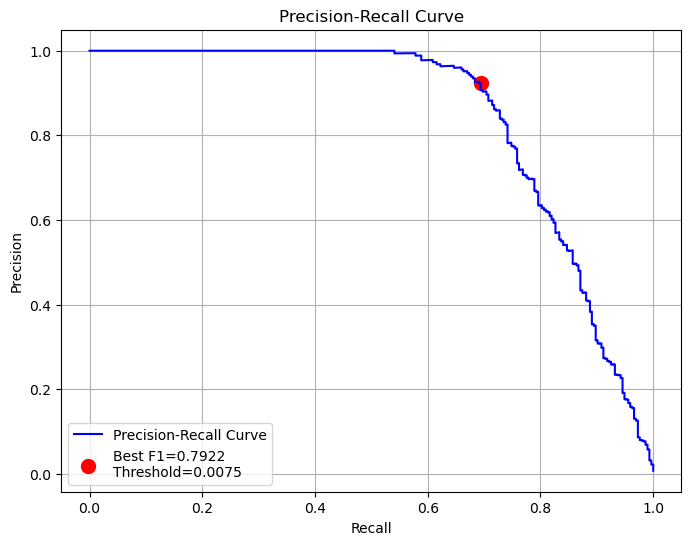

In [248]:
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve
plt.figure(figsize=(8, 6))
plt.plot(recall, precision, label='Precision-Recall Curve', color='b')
plt.scatter(recall[best_idx], precision[best_idx], color='red', s=100,
            label=f'Best F1={f1_scores[best_idx]:.4f}\nThreshold={thresholds[best_idx]:.4f}')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend()
plt.grid(True)
plt.show()

In [249]:
y_test_pred = model.predict_proba(X_test)[:, 1]
y_test_labels = (y_test_pred >= best_threshold).astype(int)
print(sum(y_test_labels))

y_priv_pred=model.predict_proba(x_priv)[:,1]
y_priv_pred = (y_priv_pred >= best_threshold).astype(int)
print(sum(y_priv_pred))

/home/zihui/miniconda3/envs/env/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


136


/home/zihui/miniconda3/envs/env/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


142


In [250]:
with open('ans.txt','w') as f:
    for i in y_test_labels.flatten():
        f.write(str(i)+'\n')
    for i in y_priv_pred.flatten():
        f.write(str(i)+'\n')